## Instructions {-}

- This is the template for the code and report on the Prediction Problem assignments.

- Your code in steps 1, 3, 4, and 5 will be executed sequentially, and must produce the RMSE / accuracy claimed on Kaggle.

- Your code in step 2 will also be executed, and must produce the optimal hyperparameter values used to train the model.

## Read data

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split, StratifiedKFold, GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score, mean_squared_error


os.environ["OMP_NUM_THREADS"] = "1"

warnings.filterwarnings("ignore")

In [6]:
raw_train = pd.read_csv('../../Datasets/train_classification.csv')
raw_test = pd.read_csv('../../Datasets/test_classification.csv')

## 1) Data pre-processing

Put the data pre-processing code. You don't need to explain it. You may use the same code from last quarter.

In [7]:
# Create copies of the raw datasets
train = raw_train.copy()
test = raw_test.copy()

# Convert 'host_acceptance_rate' and 'host_response_rate' columns to float and scale by dividing by 100
train['acceptance_rate'] = train['host_acceptance_rate'].str.replace('%', '').astype(float) / 100
train['response_rate'] = train['host_response_rate'].str.replace('%', '').astype(float) / 100

test['acceptance_rate'] = test['host_acceptance_rate'].str.replace('%', '').astype(float) / 100
test['response_rate'] = test['host_response_rate'].str.replace('%', '').astype(float) / 100

# Drop unnecessary columns
train.drop(columns=['host_acceptance_rate', 'host_response_rate'], inplace=True)
test.drop(columns=['host_acceptance_rate', 'host_response_rate'], inplace=True)



# Extract numeric values from 'bathrooms_text' column and convert to float
train['bathrooms_num'] = train['bathrooms_text'].str.extract('(\d+)').astype(float)
test['bathrooms_num'] = test['bathrooms_text'].str.extract('(\d+)').astype(float)

# Fill missing values in 'bathrooms_num' where 'Half-bath' is mentioned in 'bathrooms_text' with 0.5
train.loc[train['bathrooms_text'].str.contains('Half-bath', case=False, na=False) & train['bathrooms_num'].isna(), 'bathrooms_num'] = 0.5
test.loc[test['bathrooms_text'].str.contains('Half-bath', case=False, na=False) & test['bathrooms_num'].isna(), 'bathrooms_num'] = 0.5


In [8]:
# Convert date columns to datetime format
def strip_date(row):
    if isinstance(row, str):
        row = datetime.strptime(row, '%Y-%m-%d').date()
    return row

# Apply date conversion to train dataset
train['host_since'] = train['host_since'].apply(strip_date)
train['first_review'] = train['first_review'].apply(strip_date)
train['last_review'] = train['last_review'].apply(strip_date)

# Apply date conversion to test dataset
test['host_since'] = test['host_since'].apply(strip_date)
test['first_review'] = test['first_review'].apply(strip_date)
test['last_review'] = test['last_review'].apply(strip_date)

# ----- #

# Calculate months since various dates for train dataset
train['host_since_in_months'] = round(((datetime.now().date() - train['host_since']).dt.days) / 30, 2)
train['first_review_in_months'] = round(((datetime.now().date() - train['first_review']).dt.days) / 30, 2)
train['last_review_in_months'] = round(((datetime.now().date() - train['last_review']).dt.days) / 30, 2)

# Calculate months since various dates for test dataset
test['host_since_in_months'] = round(((datetime.now().date() - test['host_since']).dt.days) / 30,  2)
test['first_review_in_months'] = round(((datetime.now().date() - test['first_review']).dt.days) / 30, 2)
test['last_review_in_months'] = round(((datetime.now().date() - test['last_review']).dt.days) / 30, 2)


train_clean = train.drop(columns=['host_since', 'first_review', 'last_review'])
test_clean = test.drop(columns=['host_since', 'first_review', 'last_review'])


In [9]:
# Create a dictionary for response time category conversions
response_time_dict = {'within an hour': 1, 'within a few hours': 12, 'within a day': 24, 'a few days or more': 72}

def replace_response_time(row):
    if pd.notna(row):
        return response_time_dict.get(row)
    else:
        return None

train_clean['response_time'] = train_clean['host_response_time'].apply(replace_response_time)
test_clean['response_time'] = test_clean['host_response_time'].apply(replace_response_time)

Clean Transform

In [10]:
def clean_vars(row):
    # Check if 'shared' is in 'bathrooms_text' to identify shared bathrooms
    if 'shared' in str(row['bathrooms_text']):
        row['bathrooms_shared'] = "t"
        
    # Check if 'bathrooms_text' is empty and 'room_type' is 'Shared' to identify shared bathrooms
    elif pd.isna(row['bathrooms_text']):
        if 'Shared' in row['room_type']:
            row['bathrooms_shared'] = "t"              
        else:
            row['bathrooms_shared'] = "f"
    else: 
        row['bathrooms_shared'] = "f"
        
    # Convert 'Hotel room' room type to 'Private room'
    if row.loc['room_type'] == 'Hotel room':
        row['room_type'] = 'Private room'
        
    return row

# Apply the function to clean variables to train and test datasets
train_clean = train_clean.apply(clean_vars, axis=1)
test_clean = test_clean.apply(clean_vars, axis=1)


# create variables for rate of reviews for listing count and for host_since_months
train_clean['reviews_per_listing'] = train_clean['number_of_reviews']/train_clean['calculated_host_listings_count']
train_clean['reviews_per_month'] = train_clean['number_of_reviews']/train_clean['host_since_in_months']
train_clean['reviews_per_listing_per_month'] = train_clean['reviews_per_listing']/train_clean['host_since_in_months']

test_clean['reviews_per_listing'] = test_clean['number_of_reviews']/test_clean['calculated_host_listings_count']
test_clean['reviews_per_month'] = test_clean['number_of_reviews']/test_clean['host_since_in_months']
test_clean['reviews_per_listing_per_month'] = test_clean['reviews_per_listing']/test_clean['host_since_in_months']

train_clean.drop(columns=['bathrooms_text'], inplace=True)
test_clean.drop(columns=['bathrooms_text'], inplace=True)


clean neighbourhoods

In [11]:
# if neighbourhood has less than 150 occurances group them into 'Other'
neighbourhood_counts = train_clean['neighbourhood_cleansed'].value_counts()  
test_only_hoods = [i for i in test_clean['neighbourhood_cleansed'].unique() 
                   if i not in neighbourhood_counts 
                   and i != 'Other']


other_hoods = []
for i in neighbourhood_counts.index:
    if neighbourhood_counts[i] < 150:
        other_hoods.append(i)         
    
def clean_hoods(row):
    if row.loc['neighbourhood_cleansed'] in other_hoods or row.loc['neighbourhood_cleansed'] in test_only_hoods:
        row['neighbourhood_grouped'] = 'Other'
        
    else:    
        row['neighbourhood_grouped'] = row.loc['neighbourhood_cleansed']
        
    return row
   
    
train_clean = train_clean.apply(clean_hoods, axis=1)  
test_clean = test_clean.apply(clean_hoods, axis=1)  

In [12]:
# Clean filler words out of property types
words_to_remove = ['place', 'room', 'private', 'shared', 'entire', ' in', ' room', ' private', ' shared', ' entire', ' in',]

def remove_words(text):
    text=text.lower()
    for word in words_to_remove:
        word = word.lower()
        text = text.replace(word, '')
    return text.strip()

train_clean['property_type'] = train_clean['property_type'].apply(remove_words)
test_clean['property_type'] = test_clean['property_type'].apply(remove_words)


# group properties with less than 10 occurances into 'Other'
property_counts = train_clean['property_type'].value_counts()
keep = [i for i in property_counts.index if property_counts[i] > 10]

def clean_property(row):
    if row not in keep or row == "":
        row = 'Other'
      
    return row

train_clean['property_type_cleansed'] = train_clean['property_type'].apply(clean_property)
test_clean['property_type_cleansed'] = test_clean['property_type'].apply(clean_property)

train_filter_1 = train_clean.copy()
test_filter_1 = test_clean.copy()

In [13]:
host_hood_counts = train_filter_1['host_neighbourhood'].value_counts()
keep_host_hood = host_hood_counts[host_hood_counts >= 5].index

train_filter_1['host_neighbourhood'] = train_filter_1['host_neighbourhood'].apply(lambda x: 'Other' if x not in keep_host_hood else x)
test_filter_1['host_neighbourhood'] = test_filter_1['host_neighbourhood'].apply(lambda x: 'Other' if x not in keep_host_hood else x)

# ----- #

host_loc_counts = train_filter_1['host_location'].value_counts()
keep_host_loc = host_loc_counts[host_loc_counts >= 10].index

train_filter_1['host_location'] = train_filter_1['host_location'].apply(lambda x: 'Other' if x not in keep_host_loc else x)
test_filter_1['host_location'] = test_filter_1['host_location'].apply(lambda x: 'Other' if x not in keep_host_loc else x)


In [14]:
try:
    train_filter_1['host_verifications'] = train_filter_1['host_verifications'].apply(ast.literal_eval)
except: pass

try:
    test_filter_1['host_verifications'] = test_filter_1['host_verifications'].apply(ast.literal_eval)
except: pass


In [15]:
train_filter_1['num_verifications'] = train_filter_1['host_verifications'].apply(len)
test_filter_1['num_verifications'] = test_filter_1['host_verifications'].apply(len)

In [16]:
def split_vers(df):
    def update_verification(row):
        ver_phone = 't' if 'phone' in row['host_verifications'] else 'f'
        ver_email = 't' if 'email' in row['host_verifications'] else 'f'
        ver_work_email = 't' if 'work_email' in row['host_verifications'] else 'f'
        return pd.Series({'ver_phone': ver_phone, 'ver_email': ver_email, 'ver_work_email': ver_work_email})

    df[['ver_phone', 'ver_email', 'ver_work_email']] = df.apply(update_verification, axis=1)

    return df


train_filter_2 = split_vers(train_filter_1).drop('host_verifications', axis=1)
test_filter_2 = split_vers(test_filter_1).drop('host_verifications', axis=1)

Fill missing values

In [17]:
# Fill in remaining missing values with median for numerical columns
train_filter_3 = train_filter_2.fillna(train_filter_2.median(numeric_only=True))
test_filter_3 = test_filter_2.fillna(test_filter_2.median(numeric_only=True))

# review scores are very correlated, average review scores to handle this
train_filter_3['review_scores_avg'] = np.mean(train_filter_3[['review_scores_accuracy', 'review_scores_checkin', 'review_scores_communication', 'review_scores_rating', 'review_scores_value', 'review_scores_location', 'review_scores_cleanliness']], axis=1)
test_filter_3['review_scores_avg'] = np.mean(test_filter_3[['review_scores_accuracy', 'review_scores_checkin', 'review_scores_communication', 'review_scores_rating', 'review_scores_value', 'review_scores_location', 'review_scores_cleanliness']], axis=1)

train_filter_3.drop(columns=['review_scores_accuracy', 'review_scores_checkin', 'review_scores_communication', 'review_scores_rating', 'review_scores_value', 'review_scores_location', 'review_scores_cleanliness'], inplace=True)
test_filter_3.drop(columns=['review_scores_accuracy', 'review_scores_checkin', 'review_scores_communication', 'review_scores_rating', 'review_scores_value', 'review_scores_location', 'review_scores_cleanliness'], inplace=True)

train_filter_3['host_is_superhost'] = train_filter_3['host_is_superhost'].replace({"f":False, "t":True})


In [18]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

non_numeric_columns = train_filter_3.select_dtypes(exclude=[np.number]).columns
data_numeric = train_filter_3.drop(columns=non_numeric_columns)

X = data_numeric.drop(columns=['id', 'latitude', 'longitude'])
y = train_filter_3.host_is_superhost

vif = pd.DataFrame()
vif["Predictor"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif[vif['VIF'] >= 5].sort_values('VIF', ascending=False)

,Predictor,VIF
12,maximum_nights_avg_ntm,4.145434e+11
9,minimum_maximum_nights,2.204028e+11
10,maximum_maximum_nights,4.311439e+10
20,calculated_host_listings_count,3.714870e+04
21,calculated_host_listings_count_entire_homes,3.693185e+04
14,availability_60,2.564291e+02
26,response_rate,1.932304e+02
11,minimum_nights_avg_ntm,1.924995e+02
35,review_scores_avg,1.783457e+02
15,availability_90,1.571621e+02


In [19]:
train_filter_4 = train_filter_3.drop(columns=['maximum_nights_avg_ntm', 'minimum_nights_avg_ntm', 'calculated_host_listings_count', 'availability_60', 'host_listings_count'])  #'maximum_maximum_nights', 'minimum_maximum_nights'])
test_filter_4 = test_filter_3.drop(columns=['maximum_nights_avg_ntm', 'minimum_nights_avg_ntm', 'calculated_host_listings_count', 'availability_60', 'host_listings_count'])  # 'maximum_maximum_nights', 'minimum_maximum_nights'])

In [20]:
non_numeric_columns = train_filter_4.select_dtypes(exclude=[np.number]).columns
data_numeric = train_filter_4.drop(columns=non_numeric_columns)

X = data_numeric.drop(columns=['id', 'latitude', 'longitude'])
y = train_filter_4.host_is_superhost

vif = pd.DataFrame()
vif["Predictor"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif[vif['VIF'] >= 5].sort_values('VIF', ascending=False)

,Predictor,VIF
21,response_rate,192.277955
30,review_scores_avg,177.974268
23,host_since_in_months,70.680460
20,acceptance_rate,34.475600
0,host_id,28.452592
11,availability_90,22.778122
4,minimum_nights,17.494156
29,num_verifications,16.824776
6,minimum_minimum_nights,16.347425
16,calculated_host_listings_count_entire_homes,15.292789


In [21]:
train_filter_5 = train_filter_4.drop(columns=['response_rate', 'review_scores_avg']) #['availability_60', 'response_rate', 'availability_90', 'host_listings_count', 'review_scores_avg'])
test_filter_5 = test_filter_4.drop(columns=['response_rate', 'review_scores_avg']) #['availability_60', 'response_rate', 'availability_90', 'host_listings_count', 'review_scores_avg'])

In [22]:
non_numeric_columns = train_filter_5.select_dtypes(exclude=[np.number]).columns
data_numeric = train_filter_5.drop(columns=non_numeric_columns)

X = data_numeric.drop(columns=['id', 'latitude', 'longitude'])
y = train_filter_5.host_is_superhost

vif = pd.DataFrame()
vif["Predictor"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif[vif['VIF'] >= 5].sort_values('VIF', ascending=False)

,Predictor,VIF
20,acceptance_rate,29.535764
22,host_since_in_months,28.334959
11,availability_90,22.729588
4,minimum_nights,17.488099
6,minimum_minimum_nights,16.342689
28,num_verifications,16.165169
16,calculated_host_listings_count_entire_homes,15.292563
10,availability_30,14.066100
19,reviews_per_month,13.477886
26,reviews_per_listing,12.471451


In [23]:
train_final = train_filter_5.copy()
test_final = test_filter_5.copy()

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, GridSearchCV, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [25]:
numeric_columns = train_final.select_dtypes(include=['number']).drop(columns=['host_id', 'id']).columns

X_train = train_final.drop(columns=['host_id', 'host_is_superhost', 'id'])
X_test = test_final.drop(columns=['host_id', 'id'])
train_final
X_train_num = X_train[numeric_columns]
y_train = train_final.host_is_superhost

sc = StandardScaler()
sc.fit(X_train_num)

X_train_scaled = sc.transform(X_train[numeric_columns])
X_test_scaled = sc.transform(X_test[numeric_columns])

X_train_num_scaled = pd.DataFrame(X_train_scaled, columns=numeric_columns)
X_test_num_scaled = pd.DataFrame(X_test_scaled, columns=numeric_columns)


train_testing = train_final.drop(columns=['host_is_superhost']) 
test_testing = test_final

train_testing_cat = train_testing.select_dtypes(exclude=['number'])
test_testing_cat = test_testing.select_dtypes(exclude=['number'])


enc = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
enc.fit(train_testing_cat)

drop_enc = enc.transform(train_testing_cat)
drop_enc_test = enc.transform(test_testing_cat)

train_encoded_df = pd.DataFrame(drop_enc.toarray(), columns=enc.get_feature_names_out(train_testing_cat.columns))
test_encoded_df = pd.DataFrame(drop_enc_test.toarray(), columns=enc.get_feature_names_out(test_testing_cat.columns))

X_train_final = pd.concat([X_train_num_scaled, train_encoded_df], axis=1)
X_test_final = pd.concat([X_test_num_scaled, test_encoded_df], axis=1)

## 2) Hyperparameter tuning

### How many attempts did it take you to tune the model hyperparameters?

I had 23 attempts total between these models.

### Which tuning method did you use (grid search / Bayes search / etc.)?

I used both GridSearch for the initial search and then loops to optimize further

### What challenges did you face while tuning the hyperparameters, and what actions did you take to address those challenges?

To make sure I was finding the absolute best combination of hyperparameters--including threshold--I ran loops after gridsearch results within the ranges found by the gscv. While computationally costly, this garunteed I found the best combination of parameters.

### How many hours did you spend on hyperparameter tuning?

I believe I spent about 10 hours on this portion.

**Paste the hyperparameter tuning code below. You must show at least one hyperparameter tuning procedure.**

### Model Creation

In [25]:
warnings.filterwarnings("ignore")
oob_acc={}

for i in np.linspace(10, 300, 40, dtype=int):
    model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1), n_estimators=i, random_state=1,
                        n_jobs=-1, oob_score=True).fit(X_train_final, y_train)
    
    oob_acc[i] = model.oob_score_ 


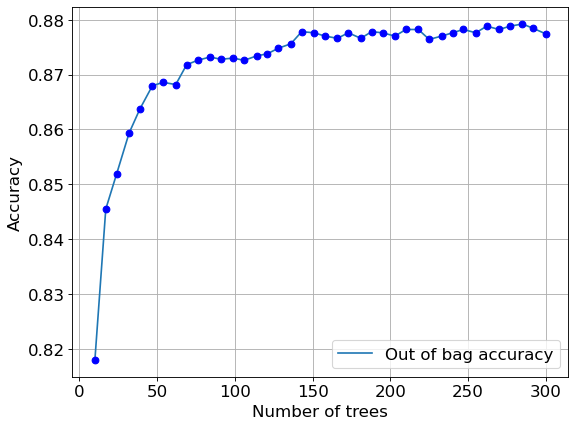

In [26]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_acc.keys(),oob_acc.values(),label = 'Out of bag accuracy')
plt.plot(oob_acc.keys(),oob_acc.values(),'o',color = 'blue')
plt.grid()
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Bagging

#### Bagging GSCV

In [28]:
params = {
    'max_samples': [0.5, 0.75, 0.9, 1.0],
    'max_features': [0.5, 0.75, 0.9, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

cv_settings = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
base_model = DecisionTreeClassifier(random_state=1)
bag_model_gscv1 = GridSearchCV(BaggingClassifier(estimator=base_model, n_estimators=150), params, cv=cv_settings, scoring='accuracy', verbose=2)

bag_model_gscv1.fit(X_train_final, y_train)
print(bag_model_gscv1.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END bootstrap=True, bootstrap_features=True, max_features=0.5, max_samples=0.5; total time=  10.6s
[CV] END bootstrap=True, bootstrap_features=True, max_features=0.5, max_samples=0.5; total time=   9.5s
[CV] END bootstrap=True, bootstrap_features=True, max_features=0.5, max_samples=0.5; total time=   9.5s
[CV] END bootstrap=True, bootstrap_features=True, max_features=0.5, max_samples=0.75; total time=  12.7s
[CV] END bootstrap=True, bootstrap_features=True, max_features=0.5, max_samples=0.75; total time=  12.8s
[CV] END bootstrap=True, bootstrap_features=True, max_features=0.5, max_samples=0.75; total time=  13.1s
[CV] END bootstrap=True, bootstrap_features=True, max_features=0.5, max_samples=0.9; total time=  14.6s
[CV] END bootstrap=True, bootstrap_features=True, max_features=0.5, max_samples=0.9; total time=  14.1s
[CV] END bootstrap=True, bootstrap_features=True, max_features=0.5, max_samples=0.9; total time=  13.8s

[CV] END bootstrap=True, bootstrap_features=False, max_features=0.9, max_samples=0.9; total time=  20.9s
[CV] END bootstrap=True, bootstrap_features=False, max_features=0.9, max_samples=0.9; total time=  16.2s
[CV] END bootstrap=True, bootstrap_features=False, max_features=0.9, max_samples=0.9; total time=  19.5s
[CV] END bootstrap=True, bootstrap_features=False, max_features=0.9, max_samples=1.0; total time=  23.5s
[CV] END bootstrap=True, bootstrap_features=False, max_features=0.9, max_samples=1.0; total time=  22.0s
[CV] END bootstrap=True, bootstrap_features=False, max_features=0.9, max_samples=1.0; total time=  21.1s
[CV] END bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=0.5; total time=  15.2s
[CV] END bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=0.5; total time=  16.7s
[CV] END bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=0.5; total time=  14.3s
[CV] END bootstrap=True, bootstrap_features=False, max_

[CV] END bootstrap=False, bootstrap_features=False, max_features=0.75, max_samples=0.5; total time=  16.4s
[CV] END bootstrap=False, bootstrap_features=False, max_features=0.75, max_samples=0.5; total time=  16.0s
[CV] END bootstrap=False, bootstrap_features=False, max_features=0.75, max_samples=0.5; total time=  16.2s
[CV] END bootstrap=False, bootstrap_features=False, max_features=0.75, max_samples=0.75; total time=  24.3s
[CV] END bootstrap=False, bootstrap_features=False, max_features=0.75, max_samples=0.75; total time=  24.0s
[CV] END bootstrap=False, bootstrap_features=False, max_features=0.75, max_samples=0.75; total time=  23.5s
[CV] END bootstrap=False, bootstrap_features=False, max_features=0.75, max_samples=0.9; total time=  28.8s
[CV] END bootstrap=False, bootstrap_features=False, max_features=0.75, max_samples=0.9; total time=  28.2s
[CV] END bootstrap=False, bootstrap_features=False, max_features=0.75, max_samples=0.9; total time=  27.7s
[CV] END bootstrap=False, bootstra

In [29]:
params = {
    'max_samples': np.arange(0.8, 1.02, 0.05), 
    'max_features': np.arange(0.3, 0.75, 0.05) 
}

base_model = DecisionTreeClassifier(random_state=1)
bag_model_gscv = GridSearchCV(BaggingClassifier(estimator=base_model, bootstrap=False, bootstrap_features=False, n_estimators=150), params, cv=cv_settings, scoring='accuracy', verbose=2, n_jobs=-1)

bag_model_gscv.fit(X_train_final, y_train)
print(bag_model_gscv.best_params_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


C:\Users\emmal\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\emmal\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\emmal\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\emmal\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\emmal\anaconda3\Lib\site-packages

{'max_features': 0.49999999999999994, 'max_samples': 0.9000000000000001}


#### Bagging Looping

In [23]:
params = {
    'max_features': np.arange(0.4, 0.6, 0.05), 
    'max_samples': np.arange(0.88, 0.921, 0.02),
    'thrs': np.arange(0.44, 0.53, 0.01),
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

print(len(params['max_features'])*len(params['max_samples'])*len(params['thrs'])*4, 'candidates')

bag_results_3 = pd.DataFrame(columns=['max_feats', 'max_samples','bootstrap', 'bootstrap_feat', 'thr', 'acc', 'recall'])

counter = 0
for feat in params['max_features']:
    print(feat)
    for strap in params['bootstrap']:
        for strap_feat in params['bootstrap_features']:

            for sample in params['max_samples']:
                sample = round(sample, 4)

                cv_settings = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

                bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1), max_samples=sample, max_features=feat, bootstrap=False, bootstrap_features=False, n_estimators=150).fit(X_train_final, y_train)
                pred_probas = cross_val_predict(estimator=bag_model, X=X_train_final, y=y_train, cv=cv_settings, method='predict_proba', n_jobs=-1)[:, 1]
    
                for thr in params['thrs']:
                    preds = pred_probas > thr

                    bag_results_3.loc[counter, 'max_feats'] = feat
                    bag_results_3.loc[counter, 'max_samples'] = sample
                    bag_results_3.loc[counter, 'bootstrap'] = strap
                    bag_results_3.loc[counter, 'bootstrap_feat'] = strap_feat
                    bag_results_3.loc[counter, 'thr'] = thr
                    bag_results_3.loc[counter, 'acc'] = accuracy_score(y_train, preds)
                    bag_results_3.loc[counter, 'recall'] = recall_score(y_train, preds)

                    counter += 1


bag_results_3 = bag_results_3.astype(float).sort_values(['acc', 'recall'], ascending=[False, False])
bag_loop_params = bag_results_3.iloc[0, :]


best_bag_loop_feat = bag_loop_params['max_feats']
best_bag_loop_samps = bag_loop_params['max_samples']
best_bag_loop_bootstrap = bag_loop_params['bootstrap']
best_bag_loop_bootstrap_feat = bag_loop_params['bootstrap_feat']
best_bag_loop_thr = bag_loop_params['thr']

bag_results_3.head(5)

480 candidates
0.4
0.45
0.5
0.55


,max_feats,max_samples,bootstrap,bootstrap_feat,thr,acc,recall
24,0.40,0.92,1.0,1.0,0.48,0.877436,0.902473
25,0.40,0.92,1.0,1.0,0.49,0.877034,0.896520
23,0.40,0.92,1.0,1.0,0.47,0.876633,0.912546
195,0.45,0.90,0.0,1.0,0.49,0.876030,0.892857
193,0.45,0.90,0.0,1.0,0.47,0.875829,0.906593


### Random Forest

#### RandomForest GridSearch

In [26]:
warnings.filterwarnings("ignore")
rand_forest = RandomForestClassifier(random_state=1, n_estimators=150)

grid = {
    'max_samples': np.arange(0.75, 1.01, 0.05),
    'max_features': np.arange(0.55, 1.01, 0.05),
    'bootstrap': [True, False]
}

cv_settings = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
gscv_forest_2 = GridSearchCV(rand_forest, grid, verbose=2, cv=cv_settings, n_jobs=-1)
gscv_forest_2.fit(X_train_final, y_train)

print(gscv_forest_2.best_params_)
print(gscv_forest_2.best_score_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
{'bootstrap': True, 'max_features': 0.8500000000000003, 'max_samples': 0.9500000000000002}
0.8673899939722723


In [27]:
thrs = np.arange(0.0, 1.1, 0.05)
results = pd.DataFrame(columns=['thr', 'acc', 'recall'])
pred_probas = gscv_forest_2.predict_proba(X_train_final)[:, 1]

counter = 0
for thr in thrs:
    preds = pred_probas > thr
    results.loc[counter, 'thr'] = thr
    results.loc[counter, 'acc'] = accuracy_score(y_train, preds)
    results.loc[counter, 'recall'] = recall_score(y_train, preds)
    counter += 1
    
results[(results['recall'] != 0) & (results['acc'] > 0.99)]

,thr,acc,recall
7,0.35,0.995379,1.0
8,0.4,0.999598,1.0
9,0.45,0.999799,1.0
10,0.5,1.0,1.0
11,0.55,1.0,1.0
12,0.6,0.999196,0.998168
13,0.65,0.997187,0.99359


In [28]:
forest_gscv_thr = results[(results['recall'] != 0) & (results['acc'] > 0.99)].iloc[0, :]['thr']

#### RandomForest Looping

In [31]:
params = {
    'max_features': np.arange(0.4, 0.705, 0.1), 
    'thrs': np.arange(0.4, 0.65, 0.02)
}

# print(len(feats)*len(samps)*len(thrs), 'candidates')

results_2 = pd.DataFrame(columns=['max_feats', 'max_samples', 'thr', 'acc', 'recall'])

counter = 0
for feat in params['max_features']:
    sample = None
    print(feat)
        
    cv_settings = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    forest_model = RandomForestClassifier(bootstrap=False, max_features=feat, n_estimators=150, random_state=1, n_jobs=-1)
    forest_model.fit(X_train_final, y_train)
    pred_probas = cross_val_predict(estimator=forest_model, X=X_train_final, y=y_train, cv=cv_settings, method='predict_proba', n_jobs=-1)[:, 1]

    for thr in params['thrs']:
        preds = pred_probas > thr

        results_2.loc[counter, 'max_feats'] = feat
        results_2.loc[counter, 'max_samples'] = sample
        results_2.loc[counter, 'thr'] = thr
        results_2.loc[counter, 'acc'] = accuracy_score(y_train, preds)
        results_2.loc[counter, 'recall'] = recall_score(y_train, preds)

        counter += 1
            
            
best_forest_loop_params = results_2.sort_values(['acc', 'recall'], ascending=[False, False]).iloc[0, :]
best_forest_loop_max_feats = best_forest_loop_params['max_feats']
best_forest_loop_max_samps = best_forest_loop_params['max_samples']
best_forest_loop_thr = best_forest_loop_params['thr']

results_2.astype(float).sort_values(['acc', 'recall'], ascending=[False, False]).head()


0.4
0.5
0.6
0.7


,max_feats,max_samples,thr,acc,recall
3,0.4,NaN,0.46,0.867993,0.896062
2,0.4,NaN,0.44,0.867591,0.909799
5,0.4,NaN,0.50,0.866184,0.868590
4,0.4,NaN,0.48,0.865984,0.881868
6,0.4,NaN,0.52,0.864979,0.852106


In [33]:
best_forest_params = results_2.astype(float).sort_values(['acc', 'recall'], ascending=[False, False]).iloc[0]

KNN Bagging

In [25]:
def dist_power_2(distance):
    return 1/(1e-10+distance**2)
def dist_power_3(distance):
    return 1/(1e-10+distance**3)
def dist_power_4(distance):
    return 1/(1e-10+distance**4)
def dist_power_5(distance):
    return 1/(1e-10+distance**5)

In [28]:
params = {
    'estimator__n_neighbors': np.arange(5, 100, 20),
    'estimator__weights': ['uniform', 'distance', dist_power_2, dist_power_3]
}

cv_settings = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
bag_knn_model = GridSearchCV(BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=150), params, cv=cv_settings, scoring='accuracy', verbose=2, n_jobs=-1)

bag_knn_model.fit(X_train_final, y_train)
print(bag_knn_model.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'estimator__n_neighbors': 5, 'estimator__weights': <function dist_power_2 at 0x00000247A6AC4CC0>}


In [29]:
accuracy_score(y_train, cross_val_predict(bag_knn_model.best_estimator_, X_train_final, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1)))

0.8008840667068515

**Paste the optimal hyperparameter values below.**

* Bagging - max_features: 0.40, max_samples: 0.92, bootstrap_features: 1.0, bootstrap:1.0, thr: 0.48
* RandomForest - bootstrap: False, max_feats: 0.4, thr: 0.46, acc: 0.867993, recall: 0.896062

## 3) Model

In [36]:
best_bag_loop_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1), n_estimators=150,
                                        max_samples=0.92, max_features=0.4, 
                                        bootstrap=True, bootstrap_features=True).fit(X_train_final, y_train)

best_forest_loop_model = RandomForestClassifier(bootstrap=False, max_features=0.4, n_estimators=150, random_state=1, n_jobs=-1).fit(X_train_final, y_train)

### Predict

In [32]:
# Bagging Loop predictions
y_preds_test_bag = pd.DataFrame((best_bag_loop_model.predict_proba(X_test_final)[:, 1] > 0.48)).rename({0:'predicted'}, axis=1)

# # RandomForest Loop prediction
# y_preds_test_forest = pd.DataFrame((best_forest_loop_model.predict_proba(X_test_final)[:, 1] > best_forest_loop_thr)).rename({0:'predicted'}, axis=1)


## 4) Put any ad-hoc steps for further improving model accuracy

In [34]:
overlapping_hosts = train_final[train_final['host_id'].isin(test_final['host_id'])].drop_duplicates('host_id')[['host_id', 'host_is_superhost']]

def overwrite(row):
    if row['host_id'] in overlapping_hosts['host_id'].values:
        row['predicted'] = overlapping_hosts[overlapping_hosts['host_id'] == row['host_id']]['host_is_superhost'].values[0]
    return row


predicted_values_bag = pd.concat([test_final[['id', 'host_id']], y_preds_test_bag], axis=1)
predicted_values_forest = pd.concat([test_final[['id', 'host_id']], y_preds_test_forest], axis=1)
predicted_values_knn = pd.concat([test_final[['id', 'host_id']], y_preds_test_knn], axis=1)
    
predicted_values_bag = predicted_values_bag.apply(overwrite, axis=1)
predicted_values_bag = predicted_values_bag[['id', 'predicted']].set_index('id')

predicted_values_forest = predicted_values_forest.apply(overwrite, axis=1)
predicted_values_forest = predicted_values_forest[['id', 'predicted']].set_index('id')

predicted_values_knn = predicted_values_knn.apply(overwrite, axis=1)
predicted_values_knn = predicted_values_knn[['id', 'predicted']].set_index('id')
                                
                                  

## 5) Export the predictions in the format required to submit on Kaggle

In [35]:
predicted_values_bag.to_csv('bag_model_results.csv')
# predicted_values_forest.to_csv('forest_model_results.csv')
# predicted_values_knn.to_csv('bag_knn_results.csv')